Train a simple CNN for image generation tasks.
Explore convolutional architectures for generative tasks.

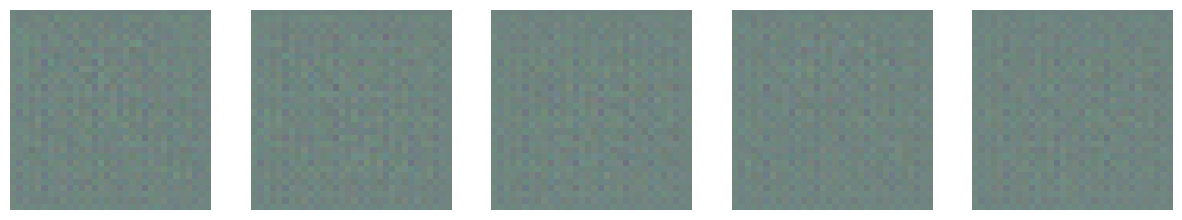

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class SimpleGenerator(nn.Module):
    def __init__(self, noise_dim=100):
        super(SimpleGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 4, 4)),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


noise_dim = 100
generator = SimpleGenerator(noise_dim=noise_dim).to(device)


def generate_images(generator, num_images=5):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, noise_dim).to(device)
        fake_images = generator(z)
        fake_images = (fake_images + 1) / 2
        return fake_images.cpu()


def plot_images(images):
    images = images.permute(0, 2, 3, 1)
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))
    for i, img in enumerate(images):
        axs[i].imshow(img.numpy())
        axs[i].axis("off")
    plt.show()


fake_images = generate_images(generator, num_images=5)
plot_images(fake_images)


100%|██████████| 170M/170M [00:05<00:00, 33.3MB/s]


Epoch [1/10], Loss: 0.0597
Epoch [2/10], Loss: 0.0651
Epoch [3/10], Loss: 0.0638
Epoch [4/10], Loss: 0.0622
Epoch [5/10], Loss: 0.0618
Epoch [6/10], Loss: 0.0596
Epoch [7/10], Loss: 0.0602
Epoch [8/10], Loss: 0.0639
Epoch [9/10], Loss: 0.0702
Epoch [10/10], Loss: 0.0606


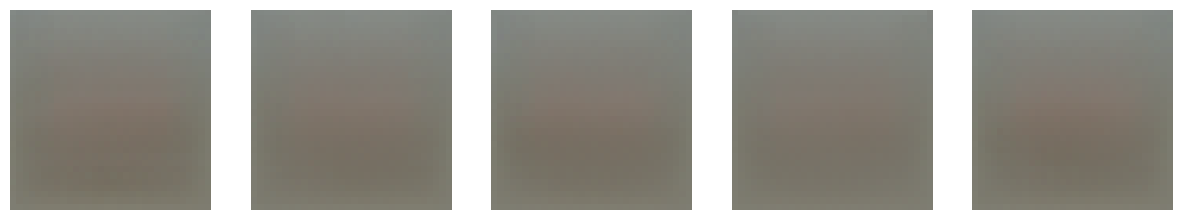

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)


class CNNDecoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(CNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

generator = CNNDecoder().to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
latent_dim = 100


num_epochs = 10
for epoch in range(num_epochs):
    for imgs, _ in trainloader:
        imgs = imgs.to(device)

        z = torch.randn(imgs.size(0), latent_dim).to(device)
        outputs = generator(z)

        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


def generate_images(generator, n=5):
    generator.eval()
    z = torch.randn(n, latent_dim).to(device)
    with torch.no_grad():
        fake_imgs = generator(z).cpu()
    return fake_imgs


def show_images(images):
    import numpy as np
    images = images.permute(0, 2, 3, 1)
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))
    for i, img in enumerate(images):
        axs[i].imshow(img.numpy())
        axs[i].axis("off")
    plt.show()


gen_imgs = generate_images(generator, 5)
show_images(gen_imgs)
